In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-classification-part-2/soil_competition-2025/sample_submission.csv
/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv
/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/465084323936570da664f0ca8dc90326.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/1aa0b12029d35e778dba5bff1255c638.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/6df2c3dcd4fb59298c7a73467ea72eeb.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/107f25ebd87f581ea57c630a2dcdf50c.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/dc35d58782615e4f9582c6b32c8b956e.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/c7af21ff925c51adb526c487148bac6d.jpg
/kaggle/input/soil-classification-part-2/soil_competition-2025/test/e8bdb9805d455093ab4f9503cad8052b.jpg
/kaggle/input/soil-class

In [2]:
import os
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [3]:
train_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train'
test_dir = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test'
train_csv_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv'
test_ids_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv'
sample_submission_path = '/kaggle/input/soil-classification-part-2/soil_competition-2025/sample_submission.csv'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
df = pd.read_csv(train_csv_path)
df['label'] = 1 

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
class SoilDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['image_id']
        label = self.df.iloc[idx]['label']
        img_path = os.path.join(self.image_dir, img_id)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [9]:
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
pseudo_negatives = torch.utils.data.Subset(cifar10, range(0, 2000))

100%|██████████| 170M/170M [00:02<00:00, 65.2MB/s]


In [10]:
class PseudoNegativeDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        return img, torch.tensor(0.0)

pseudo_negatives = PseudoNegativeDataset(pseudo_negatives)

In [11]:
train_dataset = SoilDataset(train_df, train_dir, train_transform)
train_dataset = ConcatDataset([train_dataset, pseudo_negatives])

val_dataset = SoilDataset(val_df, train_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return loss

In [13]:
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Sequential(nn.Linear(model.classifier[1].in_features, 1), nn.Sigmoid())
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 125MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [15]:
def train_model(model, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

In [16]:
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    y_pred = np.array(all_preds).flatten()
    y_true = np.array(all_labels).flatten()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Epoch 1: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Epoch 1 - Loss: 0.0166


Epoch 2: 100%|██████████| 94/94 [00:30<00:00,  3.10it/s]


Epoch 2 - Loss: 0.0060


Epoch 3: 100%|██████████| 94/94 [00:32<00:00,  2.89it/s]


Epoch 3 - Loss: 0.0014


Epoch 4: 100%|██████████| 94/94 [00:31<00:00,  2.97it/s]


Epoch 4 - Loss: 0.0007


Epoch 5: 100%|██████████| 94/94 [00:32<00:00,  2.87it/s]


Epoch 5 - Loss: 0.0057


Epoch 6: 100%|██████████| 94/94 [00:31<00:00,  3.00it/s]


Epoch 6 - Loss: 0.0016


Epoch 7: 100%|██████████| 94/94 [00:31<00:00,  2.95it/s]


Epoch 7 - Loss: 0.0012


Epoch 8: 100%|██████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch 8 - Loss: 0.0004


Epoch 9: 100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch 9 - Loss: 0.0003


Epoch 10: 100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch 10 - Loss: 0.0081
Validation Accuracy: 1.0000
Validation F1 Score: 1.0000
Classification Report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       245

    accuracy                           1.00       245
   macro avg       1.00      1.00      1.00       245
weighted avg       1.00      1.00      1.00       245



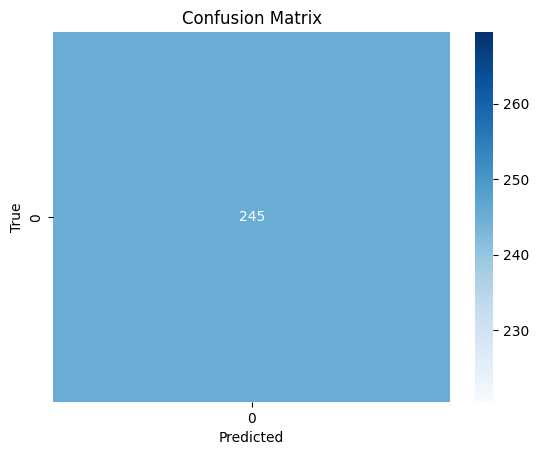

In [17]:
train_model(model, epochs=10)
evaluate_model(model, val_loader)

In [18]:
# class TestDataset(Dataset):
#     def __init__(self, image_ids, image_dir, transform=None):
#         self.image_ids = image_ids
#         self.image_dir = image_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_ids)

#     def __getitem__(self, idx):
#         img_id = self.image_ids[idx]
#         img_path = os.path.join(self.image_dir, img_id)
#         image = Image.open(img_path).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         return img_id, image

In [19]:
from sklearn.metrics import precision_recall_curve

def predict_with_tta(model, image, transforms_list):
    model.eval()
    predictions = []
    with torch.no_grad():
        for transform in transforms_list:
            augmented_image = transform(image)
            augmented_image = augmented_image.unsqueeze(0).to(device)
            output = model(augmented_image)
            predictions.append(output.item())
    return np.mean(predictions)

In [20]:
def find_best_threshold(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    all_probs = np.array(all_probs).flatten()
    all_labels = np.array(all_labels).flatten()
    precisions, recalls, thresholds = precision_recall_curve(all_labels, all_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_index = np.argmax(f1_scores)
    best_threshold = thresholds[best_index]
    print(f"Best threshold by F1: {best_threshold:.4f}, F1 Score: {f1_scores[best_index]:.4f}")
    return best_threshold

In [21]:
test_ids = pd.read_csv(test_ids_path)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    test_transform
]

In [22]:
def run_test_predictions(model, threshold=0.5):
    predictions = []
    for img_id in tqdm(test_ids['image_id'], desc="Predicting Test"):
        img_path = os.path.join(test_dir, img_id)
        image = Image.open(img_path).convert('RGB')
        prob = predict_with_tta(model, image, tta_transforms)
        label = 1 if prob > threshold else 0
        predictions.append((img_id, label))
    return predictions

In [23]:
optimal_threshold = find_best_threshold(model, val_loader)
test_predictions = run_test_predictions(model, threshold=optimal_threshold)

Best threshold by F1: 0.6357, F1 Score: 1.0000


Predicting Test: 100%|██████████| 967/967 [00:34<00:00, 27.87it/s]


In [24]:
submission_df = pd.DataFrame(test_predictions, columns=["image_id", "label"])

In [25]:
submission_df.to_csv('submission.csv', index=False)
print("Saved submission.csv")

Saved submission.csv
